In [2]:
#Import training data and convert it to dataframe

import io
import pandas as pd
import numpy as np
import csv

df= pd.DataFrame()
df= pd.read_csv('/content/drive/MyDrive/CVAssignmentDataset.csv', encoding='utf-8')
df =pd.DataFrame(df)
#df =np.asarray(df)
#df.shape
print(df)

       Class                                               Text
0        1.0  Today, Senate Dems vote to #SaveTheInternet. P...
1        1.0  RT @WinterHavenSun: Winter Haven resident / Al...
2        1.0  RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3        1.0  RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4        1.0  RT @Vegalteno: Hurricane season starts on June...
...      ...                                                ...
86456    0.0  Check out my op-ed on need for End Executive O...
86457    0.0  Yesterday, Betty &amp; I had a great time lear...
86458    0.0  We are forever grateful for the service and sa...
86459    0.0  Happy first day of school @CobbSchools! #CobbB...
86460    0.0  #Zika fears realized in Florida. House GOP act...

[86461 rows x 2 columns]


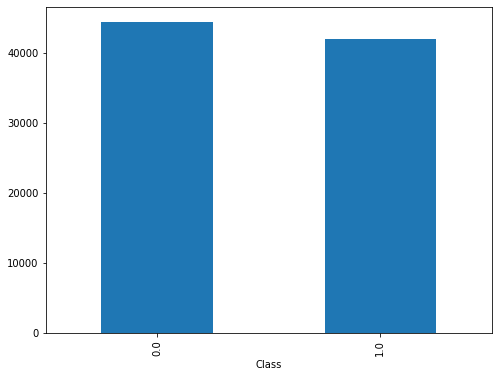

In [3]:
#Check if data is imbalanced

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Class').Class.count().plot.bar(ylim=0)
plt.show()

In [6]:
#Remove stopwords and special charactes from the dataframe

import nltk
import codecs

nltk.download("stopwords")
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
df.columns= ["Class","Text"]
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop_words)]))
df= pd.DataFrame(df)
#co^a-zA-Z0-9… 
df= df.replace('[@_!#$%^&*()<>?/|}{~:;,.…]', '',regex=True)
df
#df= float(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Class,Text
0,1.0,Today Senate Dems vote SaveTheInternet Proud s...
1,1.0,RT WinterHavenSun Winter Haven resident Alta V...
2,1.0,RT NBCLatino RepDarrenSoto noted Hurricane Mar...
3,1.0,RT NALCABPolicy Meeting RepDarrenSoto Thanks t...
4,1.0,RT Vegalteno Hurricane season starts June 1st ...
...,...,...
86456,0.0,Check op-ed need End Executive Overreach Act T...
86457,0.0,Yesterday Betty amp I great time learning fore...
86458,0.0,We forever grateful service sacrifice Major Ba...
86459,0.0,Happy first day school CobbSchools CobbBackToS...


In [7]:
#Set Max_word length and define train and validation data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen= 50
training_samples= 8000
validation_samples= 10000
max_words= 10000

tokenizer= Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Text'])
sequences= tokenizer.texts_to_sequences(df['Text'])
word_index=tokenizer.word_index
print('Found %s unique tokens'% len(word_index))

data= pad_sequences(sequences, maxlen=maxlen)
labels= np.asarray(df['Class'])
print('Shape of data tensor', data.shape)
print('Shape of label tensor', labels.shape)

indices= np.arange(data.shape[0])
np.random.shuffle(indices)
data=data[indices]
labels=labels[indices]

x_train= data[:training_samples]
y_train= labels[:training_samples]

x_val= data[training_samples:training_samples+validation_samples]
y_val= labels[training_samples: training_samples+validation_samples]

Found 135402 unique tokens
Shape of data tensor (86461, 50)
Shape of label tensor (86461,)


In [8]:
#Define the model architecture

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras.layers import Embedding, Flatten, Dense, Activation, Dropout

model = Sequential()
model.add(Embedding(max_words, 32, input_length=50))
model.add(Conv1D(32,1, activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
#model.add(Embedding(max_words, embedding_dim))
#model.add(Flatten())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            1056      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 512)           591872    
_________________________________________________________________
dropout (Dropout)            (None, 25, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [9]:
#Training the model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
63/63 [==============================] - 16s 59ms/step - loss: 0.6978 - acc: 0.5124 - val_loss: 0.6183 - val_acc: 0.6663
Epoch 2/10
63/63 [==============================] - 2s 34ms/step - loss: 0.5206 - acc: 0.7546 - val_loss: 0.6043 - val_acc: 0.7046
Epoch 3/10
63/63 [==============================] - 2s 34ms/step - loss: 0.3820 - acc: 0.8349 - val_loss: 0.5552 - val_acc: 0.7172
Epoch 4/10
63/63 [==============================] - 2s 34ms/step - loss: 0.3002 - acc: 0.8741 - val_loss: 0.6027 - val_acc: 0.7179
Epoch 5/10
63/63 [==============================] - 2s 34ms/step - loss: 0.2273 - acc: 0.9091 - val_loss: 0.8164 - val_acc: 0.7008
Epoch 6/10
63/63 [==============================] - 2s 34ms/step - loss: 0.1763 - acc: 0.9253 - val_loss: 0.9350 - val_acc: 0.7177
Epoch 7/10
63/63 [==============================] - 2s 34ms/step - loss: 0.1121 - acc: 0.9579 - val_loss: 1.0211 - val_acc: 0.7130
Epoch 8/10
63/63 [==============================] - 2s 34ms/step - loss: 0.0836 - 

In [10]:
model.evaluate(x_val, y_val)

313/313 [==============================] - 2s 6ms/step - loss: 2.2277 - acc: 0.7135


[2.22770357131958, 0.7135000228881836]

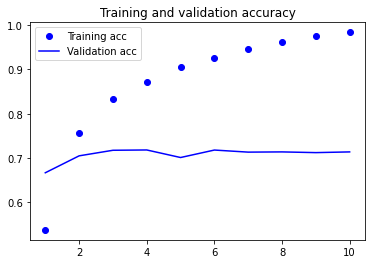

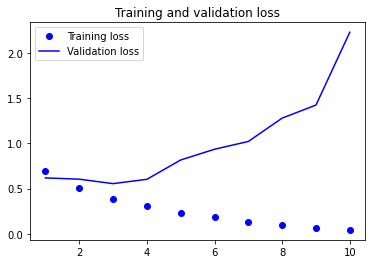

In [11]:
#Plotting training and validation accuracy

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
#model.fit(x_train, y_train, validation_data=(x_val, y_val))
y_pred = model.predict(x_val)

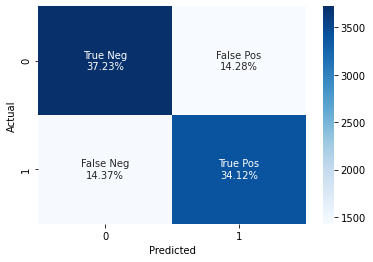

In [13]:
#Calculate confusion matrix and plotting

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_val, y_pred.round())
#print(matrix)
names = ['True Neg','False Pos','False Neg','True Pos']

#Calculate percentage for each of the names
percentage = ["{0:.2%}".format(value) for value in 
                     matrix.flatten()/np.sum(matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(names, percentage)]
          
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(matrix, annot=labels, 
            fmt='', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
#Calculate Matthew's correlation coefficient

from sklearn.metrics import matthews_corrcoef
cor_matrix= matthews_corrcoef(y_val, y_pred.round())
print(cor_matrix)

0.4264464093219898
